In [26]:
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split

import torch.nn as nn
import time
from matplotlib import pyplot as plt
from Networks_v2 import Net_Multi,Net_Individual
from Experiment_v5 import Experiment
from IPython.display import clear_output
from Check import Checkup


# Reproducibility 

In [35]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)


G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)

Device:  cpu
Random seed 2021 has been set.


# Generate the Dataset

In [36]:
WIDTH = 50
EPOCH = 20
BATCH_SIZE = 32


In [42]:
set_seed(seed=SEED)
experiment = Experiment(width = WIDTH,batch_size=BATCH_SIZE)
dataset_train,dataset_space_train,dataset_weather_train,dataset_val,dataset_space_val,dataset_weather_val,dataset_test,dataset_space_test,dataset_weather_test= experiment.Generate_data()
train_loader = torch.utils.data.DataLoader(dataset_weather_train,batch_size=10,shuffle = False )
val_loader = torch.utils.data.DataLoader(dataset_weather_val,batch_size=10,shuffle = False )
test_loader = torch.utils.data.DataLoader(dataset_weather_test,batch_size=10,shuffle = False ) #bATCH SIZE =1 HERE FOR THE DATASET ONLY, ELSE TAKE WHATEVER BATCH SIZE IN INDIVIDUAL MODE

Random seed 2021 has been set.
torch.Size([4992, 2])
torch.Size([2500])


In [44]:
y = 0

for x_train, y_train in train_loader:
    if y<1:
        print(y_train)
        print(x_train)
    y+=1

tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0.5400, 0.2400, 0.3000, 0.8800, 0.2800, 0.0000],
        [0.2400, 0.3200, 0.4000, 0.5800, 0.3800, 0.0000],
        [0.4600, 0.8200, 0.5600, 0.2600, 0.6400, 0.0000],
        [0.5800, 0.1000, 0.1800, 0.6800, 0.7400, 0.0000],
        [0.1000, 0.1200, 0.7400, 0.5800, 0.4000, 0.0000],
        [0.7000, 0.9400, 0.1400, 0.5800, 0.8600, 0.0000],
        [0.1200, 0.4000, 0.6800, 0.1400, 0.1800, 0.0000],
        [0.5600, 0.6400, 0.1400, 0.0000, 0.2000, 0.0000],
        [0.9600, 0.9000, 0.0200, 0.5600, 0.8200, 0.0000],
        [0.1000, 0.9000, 0.8200, 0.5000, 0.6200, 0.0000]])


# Initalize the Network

In [39]:

model = Net_Individual(input_dimension=5,nodes_second = 20,nodes_third = 5,nodes_output = 1)    
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.BCEWithLogitsLoss()


# Training

Epoch 19, val_loss 0.03640370722621908


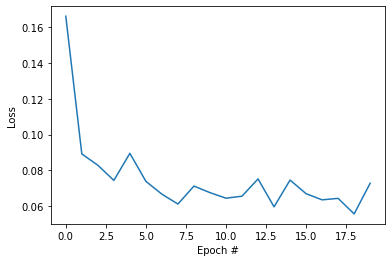

In [40]:


losses = []
val_losses = []

for epoch in range(EPOCH):

    loss = 0
    val_loss = 0 

    for x_batch, y_batch in train_loader:

        x_batch = x_batch[:,0:5]
            
        optimizer.zero_grad()
        output = model(x_batch).squeeze(1)

        output_loss = criterion(output,y_batch)
        output_loss.backward()
        optimizer.step()
            
        loss += output_loss.detach().numpy()
    losses.append(loss/len(train_loader))
            
    with torch.no_grad():
        for x_val, y_val in val_loader:
            model.eval() # not useful for now
            x_val = x_val[:,0:5]
            yhat = model(x_val).squeeze(1)
            val_loss += criterion(yhat,y_val)
        val_losses.append(val_loss.item()/len(val_loader))


    if np.mod(epoch,1)==0: 
        clear_output()
        print("Epoch {}, val_loss {}".format(epoch, val_loss.item()/len(val_loader))) 
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(val_losses)), val_losses)
        plt.ylabel('Loss')
        plt.xlabel('Epoch #')
        plt.show()
            
            



# Accuracy Score

In [41]:
checkUP = Checkup() 
EPSILON = 0.3
checkUP.Display_Score(model,test_loader, EPSILON,True,False)

Data tensor([[0.3800, 0.7800, 0.5600, 0.4400, 0.7200],
        [0.4600, 0.5200, 0.5400, 0.5400, 0.8600],
        [0.5200, 0.5200, 0.7800, 0.9800, 0.0600],
        [0.8000, 0.1000, 0.0800, 0.6000, 0.0600],
        [0.8800, 0.5000, 0.8400, 0.6600, 0.7600],
        [0.9200, 0.8400, 0.5000, 0.4400, 0.3600],
        [0.0800, 0.8400, 0.2600, 0.5000, 0.4800],
        [0.7200, 0.0600, 0.1000, 0.2200, 0.1800],
        [0.4400, 0.7000, 0.4200, 0.4800, 0.6800],
        [0.9400, 0.9200, 0.8000, 0.0200, 0.3200],
        [0.3200, 0.7000, 0.7600, 0.6400, 0.8200],
        [0.6600, 0.4800, 0.0000, 0.2400, 0.1400],
        [0.7200, 0.4800, 0.4000, 0.2600, 0.6400],
        [0.7800, 0.2800, 0.0200, 0.5400, 0.0000],
        [0.7600, 0.6000, 0.3800, 0.2400, 0.2200],
        [0.5800, 0.0400, 0.5400, 0.0000, 0.7400],
        [0.7800, 0.7600, 0.2000, 0.3400, 0.9000],
        [0.2000, 0.1000, 0.0400, 0.8200, 0.4400],
        [0.4200, 0.4000, 0.0800, 0.0600, 0.8800]])
Target tensor([1., 0., 0., 0., 1., 1., 1., 1